In [1]:
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy import special
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
data2014 = pd.read_csv("Our_Dataset/2014dataset.csv")
data2015 = pd.read_csv("Our_Dataset/2015dataset.csv")
data2016 = pd.read_csv("Our_Dataset/2016dataset.csv")
data2017 = pd.read_csv("Our_Dataset/2017dataset.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,52,323,649,882,932,1092,1202) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,57,204,341,376,377,396,430,431,928,944,1006,1013,1151,1160,1169,1179,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,17,163,355,406,702,835,847,1083,1156,1183,1185,1200) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Create the labels.
# By index:
# label 2 is transfers
# label 3 is premiums
# label 4 is costs
# label 5 is member months
# label 6 is reinsurance (individual group only)

ind_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                  "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
                  "1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "STATE", "REINSURANCE PAYMENT AMOUNT (OR NOT ELIGIBLE)"] # no more reinsurance as of 2017
ind_labels_15 = [label.replace('15', '16') for label in ind_labels_14]
ind_labels_16 = [label.replace('15', '17') for label in ind_labels_14]
ind_labels_17 = [label.replace('15', '18') for label in ind_labels_14][:-1]

sg_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                 "HHS RISK ADJUSTMENT TRANSFERS AMOUNT (SMALL GROUP MARKET)",
                  "1.1Directpremiumwritten7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "2.16Totalincurredclaims7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15", "STATE"]
sg_labels_15 = [label.replace('15', '16') for label in sg_labels_14]
sg_labels_16 = [label.replace('15', '17') for label in sg_labels_14]
sg_labels_17 = [label.replace('15', '18') for label in sg_labels_14]

In [4]:
# Filter the data to include only the fields we want

ind_data_14 = data2014[ind_labels_14].dropna()
ind_data_15 = data2015[ind_labels_15].dropna()
ind_data_16 = data2016[ind_labels_16].dropna()
ind_data_17 = data2017[ind_labels_17].dropna()
sg_data_14 = data2014[sg_labels_14].dropna()
sg_data_15 = data2015[sg_labels_15].dropna()
sg_data_16 = data2016[sg_labels_16].dropna()
sg_data_17 = data2017[sg_labels_17].dropna()

In [5]:
# Drop companies with <2000 MM
ind_data_14 = ind_data_14.where(ind_data_14[ind_labels_14[5]] > 2000).dropna()
ind_data_15 = ind_data_15.where(ind_data_15[ind_labels_15[5]] > 2000).dropna()
ind_data_16 = ind_data_16.where(ind_data_16[ind_labels_16[5]] > 2000).dropna()
ind_data_17 = ind_data_17.where(ind_data_17[ind_labels_17[5]] > 2000).dropna()
sg_data_14 = sg_data_14.where(sg_data_14[sg_labels_14[5]] > 2000).dropna()
sg_data_15 = sg_data_15.where(sg_data_15[sg_labels_15[5]] > 2000).dropna()
sg_data_16 = sg_data_16.where(sg_data_16[sg_labels_16[5]] > 2000).dropna()
sg_data_17 = sg_data_17.where(sg_data_17[sg_labels_17[5]] > 2000).dropna()

In [6]:
# Calculate transfers, premiums, costs, and reinsurance (if individual group) per member month
def calculate_pmm(df, df_labels, group):
    df["MM"] = df[df_labels[5]]
    df["Transfers"] = df[df_labels[2]]
    df["Enrollees"] = df["MM"] / 12
    df["TransfersPerEnrollee"] = df["Transfers"] / df["Enrollees"]
    df["TransfersPerSqrtEnrollee"] = df["Transfers"] / np.sqrt(df["Enrollees"])
    df["LogEnrollees"] = np.log(df["Enrollees"])
    df["LogTransfers"] = np.log(df["Transfers"]**2 + 1)
    df["TransfersPMM"] = df[df_labels[2]] / df[df_labels[5]]
    df["PremiumsPMM"] = abs(df[df_labels[3]] / df[df_labels[5]])
    df["CostsPMM"] = abs(df[df_labels[4]] / df[df_labels[5]])
    if group == "i":
        df["ReinsurancePMM"] = df[df_labels[7]] / df[df_labels[5]]
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"] + df["ReinsurancePMM"]
        #df["PremMinusCostsPlusReinsurancePMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["ReinsurancePMM"]
    elif group == "sg":
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["PremMinusCostsPMM"] = df["PremiumsPMM"] - df["CostsPMM"]
    df["PremMinusCostsPlusTransfersPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["SicknessPMM"] = df["CostsPMM"] - df["PremiumsPMM"]
    average_sickness = np.mean(df["SicknessPMM"])
    df["ExcessSicknessPMM"] = df["SicknessPMM"] - average_sickness
    return df

ind_data_14 = calculate_pmm(ind_data_14, ind_labels_14, "i")
ind_data_15 = calculate_pmm(ind_data_15, ind_labels_15, "i")
ind_data_16 = calculate_pmm(ind_data_16, ind_labels_16, "i")
ind_data_17 = calculate_pmm(ind_data_17, ind_labels_17, "sg")
sg_data_14 = calculate_pmm(sg_data_14, sg_labels_14, "sg")
sg_data_15 = calculate_pmm(sg_data_15, sg_labels_15, "sg")
sg_data_16 = calculate_pmm(sg_data_16, sg_labels_16, "sg")
sg_data_17 = calculate_pmm(sg_data_17, sg_labels_17, "sg")

In [7]:
# Combine the dataframes by left merging

ind_data = ind_data_14.merge(ind_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(ind_data_16, on='HIOS ID', how='outer').merge(ind_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [8]:
# Do the same thing for small group

sg_data = sg_data_14.merge(sg_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(sg_data_16, on='HIOS ID', how='outer').merge(sg_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [9]:
sg_data.shape

(611, 85)

In [10]:
def plot(df, label, show_graphs):
    no_nulls = df[['LogEnrollees', 'LogTransfers']].dropna()
    X = no_nulls[['LogEnrollees']]
    y = no_nulls['LogTransfers']
    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()
    equation = "Log T = %f + %f * Log Enrollees" % (est.params[0], est.params[1])
    if show_graphs:
        fig, ax = plt.subplots(figsize=(8,8))
        plt.scatter(df["LogEnrollees"], df["LogTransfers"])
        x = np.linspace(min(df["LogEnrollees"]), max(df["LogEnrollees"]), 1000)
        plt.plot(x, est.params[0] + est.params[1] * x, label=equation)
        plt.title(label)
        plt.xlabel("Log # Enrollees")
        plt.ylabel("Log Transfers^2 + 1")
        plt.legend()
        plt.show()
    print(label)
    print(equation)
    
def state(df, state):
    return df.where(df["STATE"] == state).where(df["LogTransfers"] > 2).dropna()

def remove_outliers(df):
    return df.where(df["LogTransfers"] > 2).dropna()

In [11]:
def erfinv2(sample_size):# sig):
    # erf inverse 0.5 * p/k where p=0.05
    print("Sample size %d" % (sample_size))
    return special.erfinv(1-0.5*0.05/sample_size) * np.sqrt(2)# * sig

def num_pass(df, a):
    sample_size = df.shape[0]
    count = 0
    delta = erfinv2(sample_size)
    print("Delta_0 % .3f" % (delta))
    es1 = max(abs(df["TransfersPerSqrtEnrollee"])) / delta
    print("Comparison es_0 = %.3f" % (es1))
    print("Comparison es_0*%.2f = %.3f" % (a, a*es1))
    
    for index, row in df.iterrows():
        t = row["Transfers"]
        n = row["Enrollees"]
        if abs(row["TransfersPerSqrtEnrollee"]) < a*es1:
            count += 1
            print("T/sqrt(N)=%.3f \t <a*es_0 Satisfied" % (row["TransfersPerSqrtEnrollee"]))
        else:
            print("T/sqrt(N)=%.3f \t <a*es_0 NOT Satisfied \t Distance |T/sqrt(N)|-a*es_0 %.1f " % (row["TransfersPerSqrtEnrollee"], abs(row["TransfersPerSqrtEnrollee"]) - a*es1))
    return count
    
def binom(k, n, p):
    return stats.binom.cdf(k, n, p)

In [12]:
def run_stat_test(data, label, a):
    print(label)
    p01 = special.erf(a/np.sqrt(2))
    print("P01 = %.3f" % (p01))
    successes = num_pass(data, a)
    print("Number of successes: %d" % (successes))
    print("P value = %.3f" % (1- binom(successes, data.shape[0], p01)))

In [13]:
def ratio(df, v):# sig):
    # # of people where |d_i| < v
    return df["TransfersPerSqrtEnrollee"].where(abs(df["TransfersPerSqrtEnrollee"]) < v).dropna().count() / df["TransfersPerSqrtEnrollee"].count()

def ratio_list(t, v):# sig):
    # # of people where |d_i| < v
    k = len(t)
    t2 = [x for x in t if abs(x) < v]
    return len(t2) / k

In [14]:
#df = state(sg_data_14, "NY")
#k = len(df)
#v = np.linspace(0, max(df["TransfersPerSqrtEnrollee"]), 1000)
#v = v[1:len(v)-2]

In [15]:
this_nb_state = "CA"

In [16]:
this_nb_state = "WI"

df2 = state(sg_data_14, this_nb_state)["TransfersPerSqrtEnrollee"]
df2 = df2.append(state(sg_data_15, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_16, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_17, this_nb_state)["TransfersPerSqrtEnrollee"])

print(max(abs(df2)))

this_nb_state = "NY"

df2 = df2.append(state(sg_data_14, this_nb_state)["TransfersPerSqrtEnrollee"])
df2 = df2.append(state(sg_data_15, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_16, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_17, this_nb_state)["TransfersPerSqrtEnrollee"])
print(max(abs(df2)))

this_nb_state = "CA"

df2 = df2.append(state(sg_data_14, this_nb_state)["TransfersPerSqrtEnrollee"])
df2 = df2.append(state(sg_data_15, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_16, this_nb_state)["TransfersPerSqrtEnrollee"]) 
df2 = df2.append(state(sg_data_17, this_nb_state)["TransfersPerSqrtEnrollee"])

90659.23436879678
645485.9232224716


In [17]:
k = len(df2)
v = np.linspace(0, max(abs(df2)), 1000)
v = v[1:len(v)]

ratios = [ratio_list(df2, vi) for vi in v]
#print(ratios)
begin_p = 5/k
end_p = 1-begin_p
start_index = 0
end_index = 0
for index, ratio2 in enumerate(ratios):
    if ratio2 >= begin_p:
        start_index = index
        break
    
for index, ratio2 in enumerate(ratios):
    if ratio2 > end_p:
        end_index = index
        break

if end_index == 0:
    end_index = len(v) - 1
    
v = v[start_index:end_index]

ratios2 = ratios[start_index:end_index]
multiplier = [np.sqrt(2)/vi for vi in v]

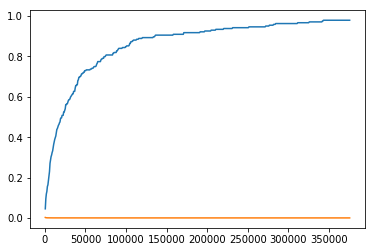

In [18]:
plt.plot(v, ratios2)
plt.plot(v, multiplier)

Text(0.5,1,'1/beta vs. v')

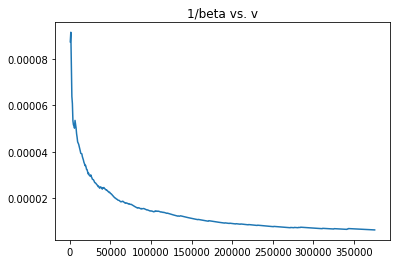

In [19]:
y = [multiplier[i] * special.erfinv(ratio2) for i, ratio2 in enumerate(ratios2)]
plt.plot(v, y)
plt.title("1/beta vs. v")

Text(0.5,1,'beta vs. v')

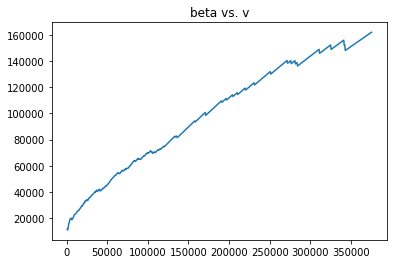

In [20]:
beta = [1/yi for yi in y]
plt.plot(v, beta)
#plt.axvline(x=64432.69, color='r', linestyle='--', label="Point of max difference")
plt.title("beta vs. v")

In [21]:
# Finding the minimum beta
# Whenever we reject a beta, we reject all betas greater than that,
# so keep pushing beta smaller until we reach max_difference == test_statistic
# Run test for larger data sizes (combining states, years)

In [22]:
max_beta=max(beta)

In [23]:
max_beta = int(max_beta/100)*100

beta = 162000.000


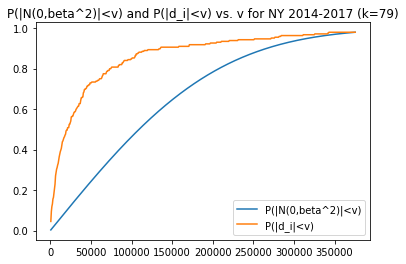

In [24]:
theoretical = [special.erf(vi/(max_beta*np.sqrt(2))) for vi in v]

plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v)")
plt.plot(v, ratios2, label="P(|d_i|<v)")
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for NY 2014-2017 (k=79)")
#plt.axvline(x=64432.69, color='r', linestyle='--', label="Point of max difference")
plt.legend()
print("beta = %.3f" % (max_beta))

In [25]:
print("k = %d" % (len(df2)))

greatest_diff = 1
test_stat = special.kolmogi(0.05)/np.sqrt(k)
print("test_stat at this k = %.5f" % (test_stat))

beta1 = max_beta

while greatest_diff > test_stat:
    theoretical = [special.erf(vi/(beta1*np.sqrt(2))) for vi in v]

    Mb_index = -1
    greatest_diff = 0
    for i, vi in enumerate(v):
        vb =  ratios2[i]-theoretical[i]
        if vb > greatest_diff:
            greatest_diff = vb
            Mb_index = i

    if greatest_diff > test_stat:
        print("\nAt the point of maximum difference with beta = %d:" % (beta1))
        print("P(|d_i|<v) = %.4f" % (ratios2[Mb_index]))
        print("P(|N(0,max_beta^2)|<v) = %.4f" % (theoretical[Mb_index]))
        print("Difference = %.4f" % (greatest_diff))
        #print("beta at this point = %.3f" % (beta[Mb_index]))
        #print(greatest_diff > test_stat)

        print("\n\n")
        beta1 = beta1 - 10000

k = 244
test_stat at this k = 0.08694

At the point of maximum difference with beta = 162000:
P(|d_i|<v) = 0.7131
P(|N(0,max_beta^2)|<v) = 0.2199
Difference = 0.4932




At the point of maximum difference with beta = 152000:
P(|d_i|<v) = 0.7131
P(|N(0,max_beta^2)|<v) = 0.2340
Difference = 0.4792




At the point of maximum difference with beta = 142000:
P(|d_i|<v) = 0.6967
P(|N(0,max_beta^2)|<v) = 0.2326
Difference = 0.4641




At the point of maximum difference with beta = 132000:
P(|d_i|<v) = 0.6967
P(|N(0,max_beta^2)|<v) = 0.2496
Difference = 0.4471




At the point of maximum difference with beta = 122000:
P(|d_i|<v) = 0.6967
P(|N(0,max_beta^2)|<v) = 0.2693
Difference = 0.4274




At the point of maximum difference with beta = 112000:
P(|d_i|<v) = 0.6967
P(|N(0,max_beta^2)|<v) = 0.2923
Difference = 0.4044




At the point of maximum difference with beta = 102000:
P(|d_i|<v) = 0.6967
P(|N(0,max_beta^2)|<v) = 0.3195
Difference = 0.3772




At the point of maximum difference with beta

In [26]:
print("k = %d" % (len(df2)))

greatest_diff = 1
test_stat = special.kolmogi(0.05)/np.sqrt(k)
print("test_stat at this k = %.5f" % (test_stat))

beta1 = beta1 + 10000

while greatest_diff > test_stat:
    theoretical = [special.erf(vi/(beta1*np.sqrt(2))) for vi in v]

    Mb_index = -1
    greatest_diff = 0
    for i, vi in enumerate(v):
        vb =  ratios2[i]-theoretical[i]
        #print(vb)
        if vb > greatest_diff:
            greatest_diff = abs(vb)
            Mb_index = i

    if greatest_diff > test_stat:
        print("\nAt the point of maximum difference with beta = %d:" % (beta1))
        print("P(|d_i|<v) = %.4f" % (ratios2[Mb_index]))
        print("P(|N(0,max_beta^2)|<v) = %.4f" % (theoretical[Mb_index]))
        print("Difference = %.4f" % (greatest_diff))
        #print("beta at this point = %.3f" % (beta[Mb_index]))
        #print(greatest_diff > test_stat)

        print("\n\n")
        beta1 = beta1 - 100

k = 244
test_stat at this k = 0.08694

At the point of maximum difference with beta = 32000:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1915
Difference = 0.1118




At the point of maximum difference with beta = 31900:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1920
Difference = 0.1112




At the point of maximum difference with beta = 31800:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1926
Difference = 0.1106




At the point of maximum difference with beta = 31700:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1932
Difference = 0.1101




At the point of maximum difference with beta = 31600:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1938
Difference = 0.1095




At the point of maximum difference with beta = 31500:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1944
Difference = 0.1088




At the point of maximum difference with beta = 31400:
P(|d_i|<v) = 0.3033
P(|N(0,max_beta^2)|<v) = 0.1950
Difference = 0.1082




At the point of maximum difference with beta = 3130

(0, 50000)

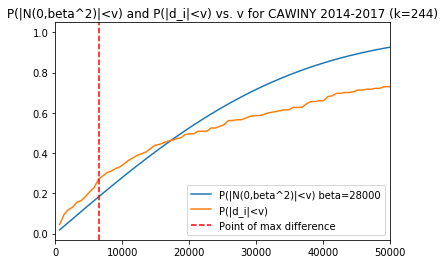

In [51]:
beta1 = beta1+100

this_nb_state = "CAWINY"
theoretical = [special.erf(vi/(beta1*np.sqrt(2))) for vi in v]

plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v) beta=%d" % (beta1))
plt.plot(v, ratios2, label="P(|d_i|<v)")
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for %s 2014-2017 (k=%d)" % (this_nb_state, k))
plt.axvline(x=v[Mb_index], color='r', linestyle='--', label="Point of max difference")
plt.legend()
plt.xlim(0, 50000)
#print("beta = %.3f" % (max_beta))

In [28]:
print("k = %d" % (len(df2)))
print("test_stat at this k = %.5f" % (test_stat))

k = 244
test_stat at this k = 0.08694


In [29]:
max(abs(df2))

645485.9232224716

In [96]:
this_nb_state = "WI"

df3 = state(sg_data_14, this_nb_state)
df3 = df3.append(state(sg_data_15, this_nb_state))
df3 = df3.append(state(sg_data_16, this_nb_state)) 
df3 = df3.append(state(sg_data_17, this_nb_state))

#print(max(abs(df3)))

this_nb_state = "NY"

df3 = df3.append(state(sg_data_14, this_nb_state))
df3 = df3.append(state(sg_data_15, this_nb_state))
df3 = df3.append(state(sg_data_16, this_nb_state)) 
df3 = df3.append(state(sg_data_17, this_nb_state))
#print(max(abs(df3)))

this_nb_state = "CA"
df3 = df3.append(state(sg_data_14, this_nb_state))
df3 = df3.append(state(sg_data_15, this_nb_state))
df3 = df3.append(state(sg_data_16, this_nb_state)) 
df3 = df3.append(state(sg_data_17, this_nb_state))

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [97]:
all_transfers = list()
mu = 0
es = 600

for a in range(5):
    all_costs = list()
    for _, row in df3.iterrows():
        all_costs.append(np.random.normal(mu, es* np.sqrt(row["Enrollees"])))
        
    c_mean = sum(all_costs) / sum(df3["Enrollees"])
    
    i = 0
    for _, row in df3.iterrows():
        all_transfers.append(all_costs[i] - c_mean*row["Enrollees"])
        i += 1


#all_costs

In [98]:
all_transfers2 = list()
mu = 0
es = 400

for a in range(5):
    all_costs = list()
    for _, row in df3.iterrows():
        all_costs.append(np.random.normal(mu, es* np.sqrt(row["Enrollees"])))
        
    c_mean = sum(all_costs) / sum(df3["Enrollees"])
    
    i = 0
    for _, row in df3.iterrows():
        all_transfers2.append(all_costs[i] - c_mean*row["Enrollees"])
        i += 1


#all_costs

In [99]:
ratios_c = [ratio_list(all_transfers, vi) for vi in v]
ratios_c2 = [ratio_list(all_transfers2, vi) for vi in v]

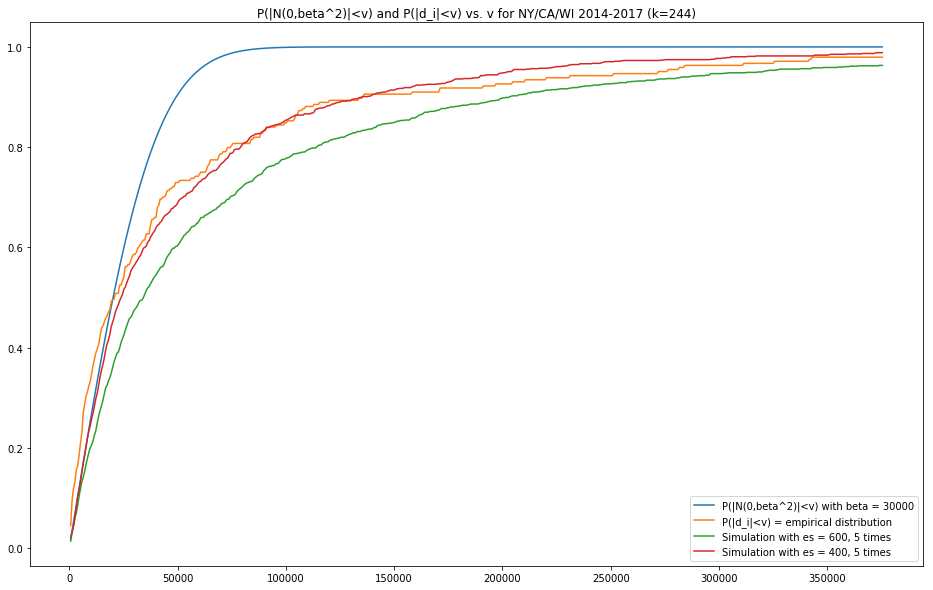

In [100]:
theoretical = [special.erf(vi/(30000*np.sqrt(2))) for vi in v]

plt.figure(figsize=(16, 10))
plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v) with beta = 30000")
plt.plot(v, ratios2, label="P(|d_i|<v) = empirical distribution")
plt.plot(v, ratios_c, label="Simulation with es = 600, 5 times")
plt.plot(v, ratios_c2, label="Simulation with es = 400, 5 times")
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for NY/CA/WI 2014-2017 (k=244)")
plt.legend()

In [36]:
np.random.normal(0, 1, 100)

array([ 1.44215271,  0.43128999,  0.7268354 , -0.03820554,  0.28197197,
       -1.65544105, -0.78426206, -1.58301797,  0.46710448, -1.68426513,
        0.3466137 ,  1.75722643,  0.02298991,  0.89420211, -0.34178849,
        1.27677218,  0.04582201,  0.58818761,  0.07973629, -0.68555966,
        2.02470362,  0.18265212,  0.30075836, -0.40518601, -0.31532831,
       -0.33736093,  0.62769724, -1.34988343, -0.26786871,  0.03690244,
       -1.42300157, -0.73318494, -0.43293249, -0.212732  , -1.61948655,
       -1.440247  ,  0.44128227, -0.91971681, -1.61379513, -0.24899636,
        0.3402631 , -0.6095538 ,  0.21206543,  1.20079185,  0.31913303,
       -1.77738812,  0.31375204, -1.69466784, -0.95228449,  1.10438921,
        0.41663944,  0.15143078,  0.1200052 , -1.37151119,  0.24696617,
       -0.53802321, -0.84986507,  0.14994441,  0.93852072, -1.45346741,
       -1.20567077,  1.00307248, -0.42883867,  1.28460868,  0.27675888,
        1.84380485,  1.49020289,  0.49516247,  0.09446766, -0.00

In [49]:
np.mean(np.sqrt(df3["Enrollees"]))

159.39624368133735

In [47]:
len(df3)

244